In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from Bio import SeqIO
import tarfile
import gzip
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import plot_intersection_bars, plotting_parameters, sort_filters



Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4413966/matplotlib-al4j3d4k because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# INPUTS 

order_background = ['01', '12', '1X', '1A', '32', '3X', '3A']
order_foreground = ['025', '021', '0A5', '0A1', '0AN']

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'

save_folder = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots'

# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
color1 = 'gold'
color2 = 'crimson'
color3 = 'mediumblue'
color4 = 'k'
colorgrid = 'grey'



save = False
sample = None

# Initialize plotting parameters
param_object = plotting_parameters(ticks_fontsize, axislabels_fontsize, legend_fontsize, axes_fontsize)
param_object.add_saving_instructions(save, run_type_plot_dir, sample_plot_dir)
param_object.add_color_options(color1, color2, color3, color4, colorgrid)



# Plot: Results per experiment

In [3]:
def calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=1):
    # Restrict table to cohort
    all_samples = [s for s in run_type_plot_dir 
                   if run_type_plot_dir[sample] == run_type_plot_dir[s]]
    df = df.set_index('sample').loc[all_samples].reset_index()
    
    
    # Compute means and std
    df_means = df.groupby(group_cols)[target_cols].mean().reset_index().rename({col : 'mean_' + col 
                                                                     for col in target_cols}, axis = 1)
    df_std = df.groupby(group_cols)[target_cols].std().reset_index().rename({col : 'std_' + col 
                                                                     for col in target_cols}, axis = 1)

    df = df.merge(df_means, on = group_cols).merge(df_std, on = group_cols)
    
    for col in df.columns:
        if ('mean_' in col):
            df[col] = [np.round(i, decimals) for i in df[col]]
            if decimals == 0:
                df[col] = [int(i) for i in df[col]]
    return df

In [4]:
# Wrapper for plotting function 
def run_sample_plotting_overlap_filter(sample, df, param_object):

    # Ordering
    df_plot = sort_filters(df, order_background, order_foreground)
    df_plot = df_plot.loc[df_plot['sample'] == sample]
    
    # Plotting labels and ticks
    param_object.add_x_label('GTEX (reads, samples)', 
                             f'{param_object.run_type_plot_dir[sample].upper()} (min, reads, samples)')
    
    param_object.add_ticks(df_plot['filter_background'], df_plot['filter_foreground'] )
    
    
    param_object.add_plotting_data(data_eth=df_plot, 
                                   data_ohsu=df_plot, 
                                   data_both=df_plot, 
                                   serie_index='index', 
                                   serie_intersection='mean_size_intersection',
                                   serie_eth='mean_size_eth', 
                                   serie_ohsu='mean_size_ohsu')
    
    param_object.add_y_label('Number of filtered junction-9mers')
    
    name_file = f'Barplot_overlap_filtering'
    if param_object.log_scale:
        name_file += '_log'
    param_object.add_saving_path(param_object.sample_plot_dir[sample], sample,
                                 name_file)
    
    param_object.add_labels('Mean intersection size', 'Mean total set size Graph Pipeline',
                            'Mean set size Junction Pipeline')
    
    param_object.add_title(f'')

    # Plotting function
    plot_intersection_bars(param_object)
    return df_plot

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


next
next
next
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_overlap_filtering_log.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:224: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


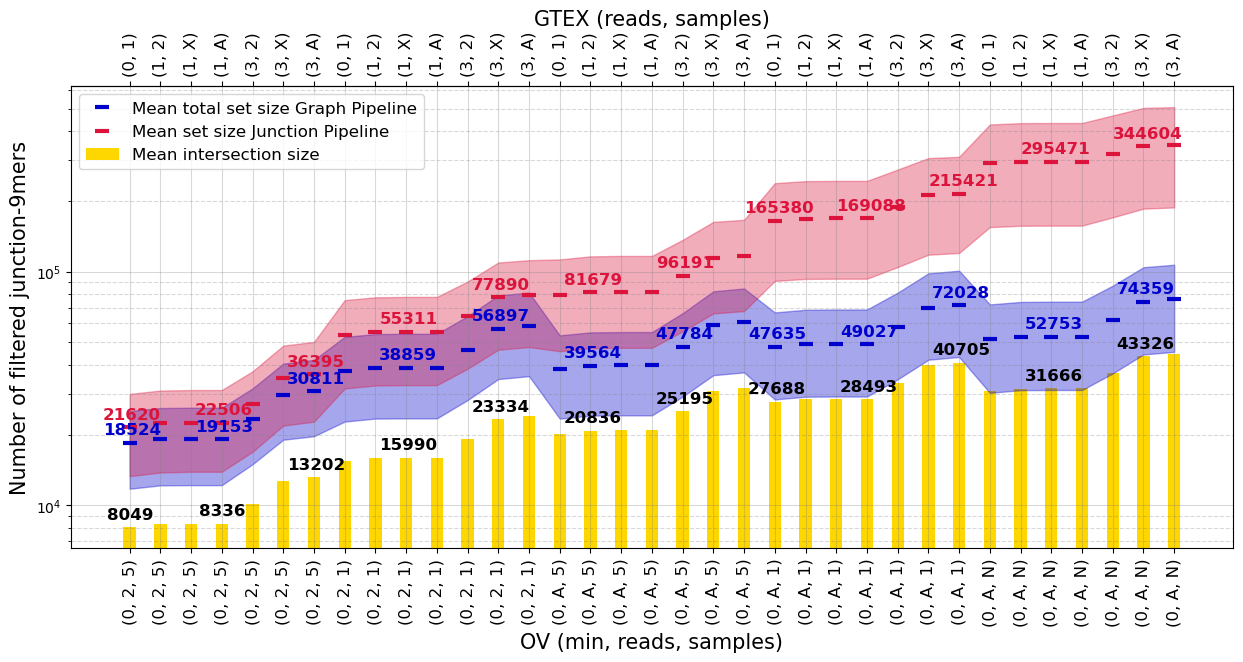

 Reading ['/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_ov.tsv.gz', '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/data_plots/data_kmers_filtering_ohsu_eth_brca.tsv.gz']


,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu
0,TCGA-25-1313-01A-01R-1565-13,0AN1XGA,137232,31576,19025,118207,12551
1,TCGA-25-1319-01A-01R-1565-13,0A501GA,88503,41552,22489,66014,19063
2,TCGA-25-1313-01A-01R-1565-13,0AN1AGA,137232,31576,19025,118207,12551
3,TCGA-24-2298-01A-01R-1569-13,0A501GA,109227,54266,27949,81278,26317
4,TCGA-61-2008-01A-02R-1568-13,0AN3AGA,489800,102480,60116,429684,42364


next
next
next
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_overlap_filtering_log.pdf


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:224: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=param.colorgrid, linestyle='--', alpha=alpha_grid)


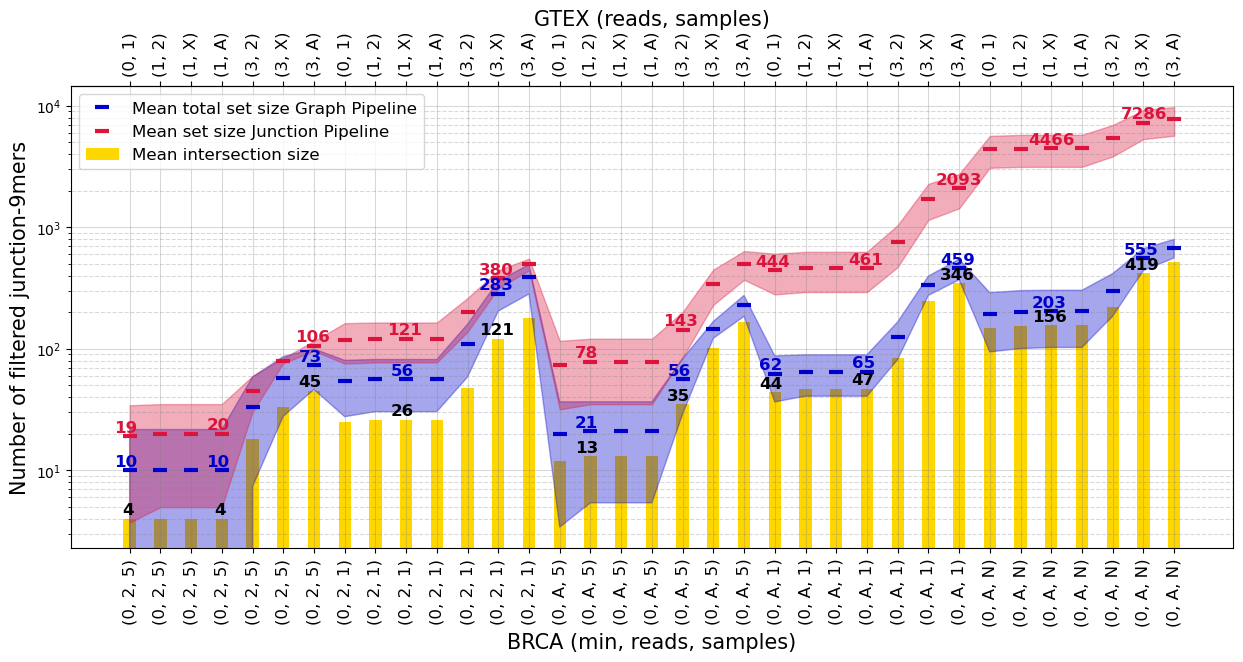

In [5]:
# MAIN 


for sample in ['TCGA-25-1319-01A-01R-1565-13', 'TCGA-AO-A0JM-01A-21R-A056-07']:
    # Intermediate paths filtering
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')

    # Intermediate data path MS results
    path_data_pep = glob.glob(os.path.join(save_folder, f'data_kmers_filtering_ohsu_eth*.tsv.gz'))

    # Read data and plot
    group_cols = ['filter_']
    target_cols = ['size_ohsu', 'size_eth', 'size_intersection', 
                      'size_ohsu\eth', 'size_eth\ohsu']
    print(f' Reading {path_data_pep}')
    df = pd.concat([pd.read_csv(path_data, sep = '\t') for path_data in path_data_pep])
    display(df.head())
    df = calculate_mean_std(df, group_cols, target_cols, run_type_plot_dir, sample, decimals=0)
    param_object.edit_marker(marker_type = "_", marker_size = 10, markeredgewidth=3)
    param_object.edit_scale(is_log_scale=True)
    df_plot = run_sample_plotting_overlap_filter(sample, df, param_object)


In [6]:
digits = 2
(1/(digits*2))

0.25

In [7]:
2/4

0.5